# Simulation Workflow Execution — Usage Guide

This notebook introduces the `Pipeline` class used to build and run full or partial **simulation workflows** in ChestXSim. 

Across previous notebooks we explored:
- core data structures (VolumeData, metadata),
- coordinate conventions,
- preprocessing / projection / reconstruction steps,
- reading and saving mechanisms

Here we **bring everything together** and demonstrate how the pipeline provides a unified execution interface for running complete simulations. 

The `Pipeline` class enables you to:
- create workflows **manually** by adding steps one by one, or
- build them automatically from a configuration dictionary.

It supports full simulations or module-only execution using the mode flag:

- 0 → preprocessing only
- 1 → projection only
- 2 → reconstruction only
- None → full pipeline


### Overview 

The `Pipeline` class is a lightweight orchestrator that executes a sequence of callable steps on a VolumeData object.

**Recall from previous notebooks:**

- A step is any class implementing `__call__(self, data: VolumeData) -> VolumeData`, performing one transformation (bed removal, tissue segmentation, projection, etc.).
- Each step records its output inside metadata.step_outputs so the workflow is fully logged.
- The pipeline simply:
     - Stores the steps,
     - Runs them sequentially,
     - Saves intermediate outputs when save=True.

**Geometry & Operator Injection**  
When building from a config dictionary, the pipeline can automatically:
- attach the correct geometry,
- create or reuse the appropriate projection/reconstruction operator
- inject source models into physics steps.

Operators are cached internally to avoid costly re-initialization.

**Saving Mechanics**  
Whenever a step is added with `save=True`, the pipeline writes:
- the binary volume/projection (.img),
- an accompanying info.txt (shape, voxel size, dtype),
- a log.txt (step-specific metadata).
Saving paths are resolved relative to Pipeline(base_save_dir="...").


#### Example 1 — Creating a Pipeline Manually

[Pipeline] Pipeline execution started.
[Pipeline] Number of steps: 9
[Pipeline] (0/9) BedRemover — running
[BedRemover] Saving mask to: D:\bhermosi\chestxsim-project\results\CT_bed_mask\NODULO_S18_S20_vx_0.84_0.84_1.25_dim_512_512_276.img
[Pipeline] 0/9) BedRemover — done
[SaveManager] BedRemover result saved to: results\CT_without_bed\NODULO_S18_S20_1
[Pipeline] (1/9) AirCropper — running
[Pipeline] 1/9) AirCropper — done
[SaveManager] AirCropper result saved to: results\CT_air_cropped\NODULO_S18_S20_2
[Pipeline] (2/9) VolumeExtender — running
[Pipeline] 2/9) VolumeExtender — done
[SaveManager] VolumeExtender result saved to: results\CT_extended\NODULO_S18_S20
[Pipeline] (3/9) TissueSegmenter — running
[TissueSegmenter] Saving bone mask (analytical) to: D:\bhermosi\chestxsim-project\results\CT_tissue_masks\analytical\NODULO_S18_S20_bone_analytical_vx_0.84_0.84_1.25_dim_512_347_436.img
[TissueSegmenter] Saving soft mask (analytical) to: D:\bhermosi\chestxsim-project\results\CT_tissue_m

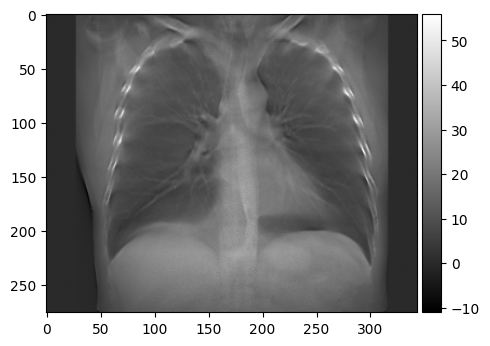

In [4]:
from chestxsim.core import Pipeline
from chestxsim.io import DicomReader
from chestxsim.core import TomoGeometry, Pipeline, SourceSpectrum
from chestxsim.wrappers import ASTRA_Tomo
from chestxsim.preprocessing import *
from chestxsim.projection import *
from chestxsim.reconstruction import *
from chestxsim.utility import plot 

# --- load CT data ---
dicom_folder = r"D:\bhermosi\chestxsim-project\inputs\NODULO\S18\S20"
reader = DicomReader(convert_to_HU=True, clip_values=(-1024, 3000))
ct_data = reader.read(dicom_folder)

# --- define source model and system geometry ---
source = SourceSpectrum(I0=1e5, voltage=120, poly_flag=True)
geo = TomoGeometry(
    detector_size=(4288, 4288),
    pixel_size=(0.1, 0.1),
    binning_proj=8,
    SDD=1800.0,
    bucky=14.47,
    step_mm=16.077,
    nprojs=61
)

#--- Create the ASTRA operator for DCT 
opt = ASTRA_Tomo(geometry=geo)

# --- define steps ---
step_bed = BedRemover(threshold=-200, save_mask=True)
step_air = AirCropper(axis=1, tol=5, delta=3, channel=0)
step_ext = VolumeExtender(ext_vals_mm=[100, 100])
step_seg = TissueSegmenter(threshold=300, tissue_types=["bone", "soft"], save_masks=True)
step_rho = UnitConverter(units="density", tissue_types=["bone","soft"], mu_factor=[2.0, 1.0])

step_proj  = Projection(opt=opt, channel_wise=True)
step_phys  = PhysicsEffect(source=source, ISL=False, apply_flood_correction=False)
step_noise = NoiseEffect(mu_dark=2.0, sigma_dark=6.0, inhomgeneities_map=None,
                         apply_flood_correction=True,log=True )

step_fdk = FDK(opt=opt, match_input=True, reco_vx=(1.25, 5.00, 1.25),
               filter_type="ramp", axis=1, padding=True)

# --- assemble pipeline ---
pipe = Pipeline(base_save_dir="results")
pipe.add(step_bed,  save=True)
pipe.add(step_air,  save=True)
pipe.add(step_ext,  save=True)
pipe.add(step_seg,  save=True)
pipe.add(step_rho,  save=True)
pipe.add(step_proj, save=True)
pipe.add(step_phys, save=True)
pipe.add(step_noise,save=True)
pipe.add(step_fdk,  save=True)

# --- run ---
out = pipe.execute(ct_data)

# visualize reconstruction
plot(out.volume.get()[:, out.volume.shape[1]//2, :, 0].T)


#### Example 2 — Building a Pipeline from a Configuration Dictionary
A configuration dictionary (or JSON file) specifies the parameters of each
module. The pipeline builder handles geometry creation and step instantiation.  

[Pipeline] Building simulation pipeline...
[Pipeline] Geometry initialized (DCT) with 61 projections.
[Pipeline] Added step: BedRemover (save=False)
[Pipeline] Added step: AirCropper (save=False)
[Pipeline] Added step: VolumeExtender (save=False)
[Pipeline] Added step: TissueSegmenter (save=False)
[Pipeline] Added step: UnitConverter (save=False)
[Pipeline] Pipeline configuration completed.
[Pipeline] Initialized operator 'astra'.
[Pipeline] Added step: Projection (save=False)
[Pipeline] Added step: PhysicsEffect (save=False)
[Pipeline] Added step: NoiseEffect (save=False)
[Pipeline] Pipeline configuration completed.
[Pipeline] Added step: FDK (save=False)
[Pipeline] Pipeline configuration completed.
[Pipeline] Pipeline execution started.
[Pipeline] Number of steps: 9
[Pipeline] (0/9) BedRemover — running
[Pipeline] 0/9) BedRemover — done
[Pipeline] (1/9) AirCropper — running
[Pipeline] 1/9) AirCropper — done
[Pipeline] (2/9) VolumeExtender — running
[Pipeline] 2/9) VolumeExtender — do

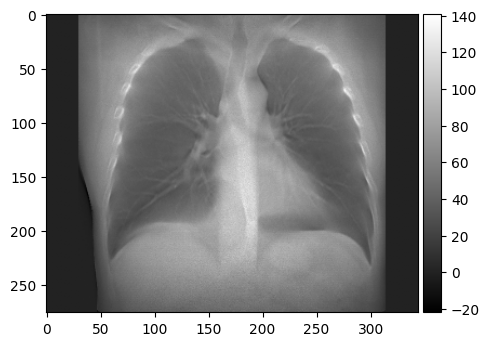

In [6]:
from chestxsim.core import build_pipeline
from chestxsim.io import RawReader
from pathlib import Path 

config = { 
    "modality": "DCT",  
    "geometry": {
        "detector_size": (4288, 4288),
        "pixel_size": (0.1, 0.1),
        "binning_proj": 4,
        "SDD": 1800.0,
        "bucky": 14.47,
        "step_mm": 16.077,
        "nprojs": 61
    },
    "preprocessing": {
        "bed_removal":   {"threshold": -200, "save_mask":False, "save": False},
        "air_cropping":  {"axis": 1, "tol": 5, "delta": 3, "channel": 0, "save": False},
        "volume_extension": {"target_height": 600.0, "chest_center": 150, "save": False},
        "tissue_segmentation": {"threshold": 300, "tissue_types": ["bone","soft"], "save": False},
        "unit_conversion": {"units": "density", "tissue_types": ["bone","soft"], "save": False}
    },
    "projection": {
        "projection":     {"opt": "astra", "channel_wise": True, "save": False},
        "Physics_effect": {"I0": 1e5, "voltage": 120, "poly_flag": True,
                           "ISL": False, "apply_flood_correction": False, "log": False, "save": False},
        "noise_effect":   {"mu_dark": 2.0, "sigma_dark": 6.0, "apply_flood_correction": True, "log": True, "save": False}
    },
    "reconstruction": {
        "FDK": { "opt": "astra", "match_input": True, "reco_vx": (1.25, 5.00, 1.25),
                "filter_type": "ramp", "axis": 1, "padding": True, "save": False}

}
}

# Run Full chain (preprocessing → projection → reconstruction)
pipe_all = build_pipeline(config, mode=None, output_folder="results")
out_all = pipe_all.execute(ct_data)
plot(out_all.volume.get()[:, out_all.volume.shape[1]//2, :, 0].T)

## Example — Running Only the Projection Stage (Preprocessed Input)

In many workflows, preprocessing is run once and reused later for different projection or reconstruction settings. Here we show how to run only the projection module on a previously saved multi-tissue density volume.

In [7]:
from chestxsim.io import RawReader
reader = RawReader()
base_path= Path(r"D:\bhermosi\chestxsim-project\examples\notebooks\results\CT_converted")
case_id = "NODULO_S18_S20"
density_data = reader.load_multi_tissue(base_path/"density", case_id, combine_method="stack")

pipe_proj = build_pipeline(config, mode=1, output_folder="results")
out_proj = pipe_proj.execute(density_data)


[RawReader] Found tissue 'bone' at D:\bhermosi\chestxsim-project\examples\notebooks\results\CT_converted\density\bone\NODULO_S18_S20
[RawReader] Found tissue 'soft' at D:\bhermosi\chestxsim-project\examples\notebooks\results\CT_converted\density\soft_tissue\NODULO_S18_S20
[Pipeline] Building simulation pipeline...
[Pipeline] Geometry initialized (DCT) with 61 projections.
[Pipeline] Initializing pipeline for projection
[Pipeline] Initialized operator 'astra'.
[Pipeline] Added step: Projection (save=False)
[Pipeline] Added step: PhysicsEffect (save=False)
[Pipeline] Added step: NoiseEffect (save=False)
[Pipeline] Pipeline configuration completed.
[Pipeline] Pipeline execution started.
[Pipeline] Number of steps: 3
[Pipeline] (0/3) Projection — running
[Pipeline] 0/3) Projection — done
[Pipeline] (1/3) PhysicsEffect — running
[PhysicsEffect] Tissue: bone at channel 0
[PhysicsEffect] Tissue: soft at channel 1
[MAC] Base folder for MACs: D:\bhermosi\chestxsim-project\materials\mac
[SourceS

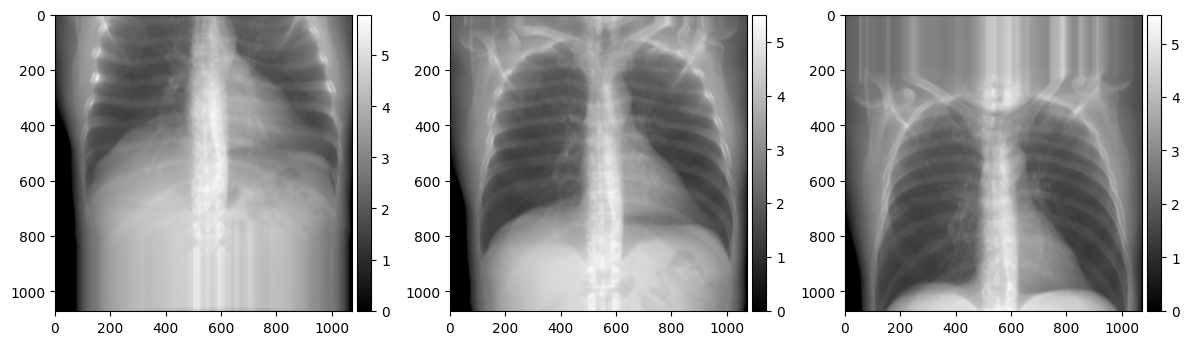

In [11]:
plot(out_proj.volume.get()[:,:, 0].T, out_proj.volume.get()[:,:, 30].T, out_proj.volume.get()[:,:, 60].T)